In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

# Homework for the DataTalks.Club Machine Learning Zoomcamp
## Week 4: Evaluation Metrics

### Getting the data

In [2]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv > data/AER_credit_card_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73250  100 73250    0     0   227k      0 --:--:-- --:--:-- --:--:--  227k


In [3]:
data = pd.read_csv('data/AER_credit_card_data.csv')
data

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


## Preparation

    Create the target variable by mapping yes to 1 and no to 0.
    Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.


In [4]:
data['card'] = data['card'].map({'yes': 1, 'no': 0})
X_full_train, X_test, y_full_train, y_test = train_test_split(data.iloc[:,1:], data.iloc[:,0], test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(data.iloc[:X_full_train.shape[0],1:], data.iloc[:X_full_train.shape[0],0], test_size=0.25, random_state=1)

In [5]:
# Checking if everything went as inteded
data.shape, X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1319, 12), (791, 11), (264, 11), (264, 11), (791,), (264,), (264,))

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the card variable.
    Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

    reports
    dependents
    active
    share


In [6]:
numerical = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active"]

for c in numerical:
    auc = roc_auc_score(y_train, X_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[c])
    print('%9s, %.3f' % (c, auc))
    

  reports, 0.703
      age, 0.506
   income, 0.576
    share, 0.991
expenditure, 0.990
dependents, 0.500
   months, 0.537
majorcards, 0.543
   active, 0.584


##### "share" has the hightest AUC Score!

## Training the model

From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


In [7]:
# One Hot Encoding categorical variables

categorical = ['owner', 'selfemp']

dv = DictVectorizer(sparse=False)

train_dict = X_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

resulting_df = pd.DataFrame(X_train)
resulting_df.columns = dv.get_feature_names_out()
resulting_df

,active,age,dependents,expenditure,income,majorcards,months,owner=no,owner=yes,reports,selfemp=no,selfemp=yes,share
0,8.0,29.75000,1.0,116.4492,3.0,1.0,12.0,0.0,1.0,0.0,1.0,0.0,0.046713
1,5.0,29.41667,3.0,126.1033,2.1,0.0,90.0,0.0,1.0,2.0,1.0,0.0,0.072297
2,17.0,25.08333,0.0,214.8600,2.1,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.122777
3,1.0,24.58333,0.0,127.1183,2.2,0.0,229.0,0.0,1.0,0.0,1.0,0.0,0.069383
4,5.0,23.83333,0.0,166.0592,3.3,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.060446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,7.0,31.66667,0.0,0.0000,7.5,1.0,30.0,1.0,0.0,3.0,1.0,0.0,0.000160
787,0.0,36.08333,2.0,0.0000,4.1,1.0,30.0,0.0,1.0,0.0,1.0,0.0,0.000293
788,0.0,38.33333,3.0,238.3650,5.0,1.0,9.0,0.0,1.0,0.0,1.0,0.0,0.057248
789,4.0,32.50000,3.0,308.2500,10.0,1.0,35.0,0.0,1.0,1.0,1.0,0.0,0.037040


In [8]:
# Training the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)


### Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.615
    0.515
    0.715
    0.995


In [9]:
# Calculating auc with sklearn
auc = roc_auc_score(y_val, y_pred)
auc

0.9853658536585366

In [10]:
# Calculating the AUC by hand for comparison
auc_helper_df = pd.DataFrame({'y_pred': y_pred, 'y_val': np.array(y_val)})
auc_helper_df['TP'] = np.where((auc_helper_df['y_pred'] == 1) & (auc_helper_df['y_pred'] == auc_helper_df['y_val']), 1, 0)
auc_helper_df['TN'] = np.where((auc_helper_df['y_pred'] == 0) & (auc_helper_df['y_pred'] == auc_helper_df['y_val']), 1, 0)
auc_helper_df['FP'] = np.where((auc_helper_df['y_pred'] == 1) & (auc_helper_df['y_pred'] != auc_helper_df['y_val']), 1, 0)
auc_helper_df['FN'] = np.where((auc_helper_df['y_pred'] == 0) & (auc_helper_df['y_pred'] != auc_helper_df['y_val']), 1, 0)
auc_helper_df

,y_pred,y_val,TP,TN,FP,FN
0,0,0,0,1,0,0
1,1,1,1,0,0,0
2,0,0,0,1,0,0
3,1,1,1,0,0,0
4,1,1,1,0,0,0
...,...,...,...,...,...,...
259,1,1,1,0,0,0
260,1,1,1,0,0,0
261,1,1,1,0,0,0
262,1,1,1,0,0,0


In [109]:
auc_helper_df.sum()

y_pred    199
y_val     205
TP        199
TN         59
FP          0
FN          6
dtype: int64

In [12]:
# Calcularing TRP and FPR
TPR = 199/(199+6)
FPR = 0/(0+59)
print(f'TPR: {TPR} and FPR: {FPR}')

TPR: 0.9707317073170731 and FPR: 0.0


### Question 3

Now let's compute precision and recall for our model.

    Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.1
    0.3
    0.6
    0.8


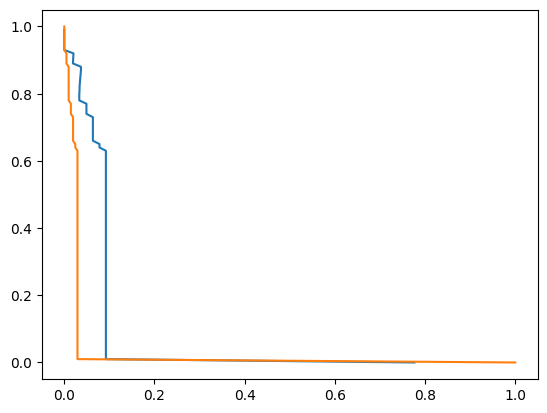

In [121]:
from sklearn.metrics import precision_recall_curve

thresholds = np.linspace(0, 1, 101)
y_pred = model.predict_proba(X_val)

precision_list = []
recall_list = []

for t in thresholds:
    prediction = np.array(list(map(lambda x:int(x[0] >= t), y_pred))) # --> converting the probabilities from y_pred into binary numbers
    
    auc_helper_df = pd.DataFrame({'y_pred': prediction, 'y_val': np.array(y_val)})
    auc_helper_df['TP'] = np.where((auc_helper_df['y_pred'] == 1) & (auc_helper_df['y_pred'] == auc_helper_df['y_val']), 1, 0)
    auc_helper_df['TN'] = np.where((auc_helper_df['y_pred'] == 0) & (auc_helper_df['y_pred'] == auc_helper_df['y_val']), 1, 0)
    auc_helper_df['FP'] = np.where((auc_helper_df['y_pred'] == 1) & (auc_helper_df['y_pred'] != auc_helper_df['y_val']), 1, 0)
    auc_helper_df['FN'] = np.where((auc_helper_df['y_pred'] == 0) & (auc_helper_df['y_pred'] != auc_helper_df['y_val']), 1, 0)
    
    TP = auc_helper_df.sum()[2]
    TN = auc_helper_df.sum()[3]
    FP = auc_helper_df.sum()[4]
    FN = auc_helper_df.sum()[5]
    
    if (TP+FP) != 0:
        precision = TP/(TP+FP)
    else:
        precision = np.nan
        
    if (TP+FN) != 0:
        recall = TP/(TP+FN)
    else:
        recall = np.nan
    
    precision_list.append(precision)
    recall_list.append(recall)

plt.plot(precision_list, thresholds);
plt.plot(recall_list, thresholds);

I have obviously made a mistake, but right now I'm in a hurry to continue with something else. So, in the best case I come back here later.